## Airline delay / cancellation dataset 
### Dimensionality Reduction, visualization, Clustering and prediction

This dataset has seen some Kaggle activity but mostly in the way of exploratory data analysis. We wanted to apply some dimensionality reduction techniques (PCA and t-SNE) to see if they would give us some insight into the data. Lower-dimensional projection is pipelined to K-means clustering to predict flight cancellations with reasonable accuracy.

In [76]:
#import all the stuff we need
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
from sklearn.utils.extmath import cartesian
from sklearn.decomposition import PCA
from sklearn import datasets, manifold
from sklearn.preprocessing import StandardScaler

from time import time

Axes3D

print(__doc__)

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='gdcutting', api_key='yWyh8TNVw5Qcrwpru9kT')

#load data from file and drop columns we already know we aren't going to use
delay_data = pd.read_csv('airlinedelaycauses/DelayedFlights.csv',sep=",", header=0,error_bad_lines=False)
delay_data.columns = ["ID","Year","Month","DayofMonth","DayOfWeek","DepTime","CRSDepTime","ArrTime","CRSArrTime","UniqueCarrier","FlightNum","TailNum","ActualElapsedTime","CRSElapsedTime","AirTime","ArrDelay","DepDelay","Origin","Dest","Distance","TaxiIn","TaxiOut","Cancelled","CancellationCode","Diverted","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]

#select only the records for cancelled flights for separate treatment
delay_data_cancelled = delay_data[delay_data["Cancelled"] == 1]

#drop non-numeric columns
delay_data = delay_data.drop(['ID','UniqueCarrier', 'TailNum','Origin','Dest','CancellationCode', 'Year','Diverted', 'FlightNum','ArrDelay','DepDelay'], axis=1)

delay_data = delay_data.fillna(0)
delay_data["MaxDelay"] = 0.0
delay_data["TotalDelay"] = 0.0

delay_data.head()
#build dataset for CANCELLATIONS
cancelled_data = delay_data.loc[delay_data['Cancelled'] == 1]


Automatically created module for IPython interactive environment


In [60]:
#dict of delay causes:
{1: "Carrier", 2: "Weather", 3: "NAS", 4: "Security", 5: "Late Aircraft"}
count = 0

base_idx = delay_data.columns.get_loc("CarrierDelay")
total_delay = []

#assign delay labels
for idx in range(1000):
    maxval = max(delay_data.iloc[idx,base_idx],delay_data.iloc[idx,base_idx+1],delay_data.iloc[idx,base_idx+2],delay_data.iloc[idx,base_idx+3],delay_data.iloc[idx,base_idx+4])
    if maxval == delay_data.iloc[idx,base_idx]:
        delay_data.iloc[idx,base_idx+5] = 1
    if maxval == delay_data.iloc[idx,base_idx+1]:
        delay_data.iloc[idx,base_idx+5] = 2
    if maxval == delay_data.iloc[idx,base_idx+2]:
        delay_data.iloc[idx,base_idx+5] = 3
    if maxval == delay_data.iloc[idx,base_idx+3]:
        delay_data.iloc[idx,base_idx+5] = 4
    if maxval == delay_data.iloc[idx,base_idx+4]:
        delay_data.iloc[idx,base_idx+5] = 5
    
    delay = delay_data.iloc[idx,base_idx] + delay_data.iloc[idx,base_idx+1] + delay_data.iloc[idx,base_idx+2] +delay_data.iloc[idx,base_idx+3] +delay_data.iloc[idx,base_idx+4]
    if delay < 30:
        total_delay.append(1)
    elif delay < 60:
        total_delay.append(2)
    elif delay < 90:
        total_delay.append(3)
    elif delay < 120:
        total_delay.append(4)
    else:
        total_delay.append(5)
    #print(row['FlightNum'])

#stitch together the cancelled records with a roughly equal number of non-cancelled
mixed_cancelled = pd.concat([cancelled_data,delay_data.head(600)])

1233


In [61]:
#reduced delay dataset
delay_data_small = delay_data.head(1000)
delay_data_small['MaxDelay'] = delay_data_small['MaxDelay'].astype(float)
delay_classes = delay_data_small[['MaxDelay']].copy()
delay_classes['TotalDelay'] = total_delay
delay_data_small = delay_data_small.drop(['CRSDepTime','CRSArrTime','CRSElapsedTime','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay', 'MaxDelay','TotalDelay'], axis=1)

cancelled_classes = mixed_cancelled[['Cancelled']].copy()
mixed_cancelled = mixed_cancelled.drop(['Cancelled','CRSDepTime','CRSArrTime','CRSElapsedTime','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay', 'MaxDelay','TotalDelay'], axis = 1)

#output classes for cancellations
cancelled_Y = np.array(cancelled_classes.Cancelled)

#data standardization
scaler = StandardScaler()
print(scaler.fit(delay_data_small))
StandardScaler(copy=True, with_mean=True, with_std=True)
print(scaler.mean_)
print(scaler.transform(delay_data_small))
delay_data_small = scaler.transform(delay_data_small)
print(delay_data_small)

StandardScaler(copy=True, with_mean=True, with_std=True)
[  1.00000000e+00   3.00000000e+00   4.00000000e+00   1.51750100e+03
   1.57069900e+03   1.16798000e+02   1.00116000e+02   7.11189000e+02
   5.16600000e+00   1.15160000e+01   0.00000000e+00]
[[ 0.          0.          0.         ..., -0.26119319 -0.63125054  0.        ]
 [ 0.          0.          0.         ..., -0.03718531 -0.27217742  0.        ]
 [ 0.          0.          0.         ..., -0.48520108  0.98457849  0.        ]
 ..., 
 [ 0.          0.          0.         ..., -0.70920896 -0.27217742  0.        ]
 [ 0.          0.          0.         ..., -0.48520108  0.98457849  0.        ]
 [ 0.          0.          0.         ..., -0.26119319 -0.45171398  0.        ]]
[[ 0.          0.          0.         ..., -0.26119319 -0.63125054  0.        ]
 [ 0.          0.          0.         ..., -0.03718531 -0.27217742  0.        ]
 [ 0.          0.          0.         ..., -0.48520108  0.98457849  0.        ]
 ..., 
 [ 0.          0.

/Users/gdcutting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [62]:
#pca for CANCELLATION
pca = PCA(n_components=3)
pca.fit(mixed_cancelled)
pca_score = pca.explained_variance_ratio_
V = pca.components_

data_2d_canc = pca.transform(mixed_cancelled)
canc_data_r = pca.fit(mixed_cancelled).transform(mixed_cancelled)
len(canc_data_r)

1233

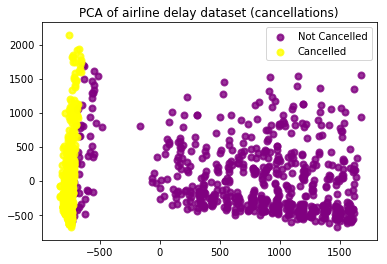

In [63]:
target_names_1 = np.array(['Not Cancelled','Cancelled'])
plt.figure()
colors_1 = ['purple','yellow']
lw = 2
cm = plt.get_cmap('jet')

for color, i, target_name in zip(colors_1, [0,1], target_names_1):
    plt.scatter(canc_data_r[cancelled_Y == i, 0], canc_data_r[cancelled_Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name, cmap=cm)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of airline delay dataset (cancellations)')

plt.show()

In [64]:
#PCA for max delay
pca = PCA(n_components=3)
pca.fit(delay_data_small)
pca_score = pca.explained_variance_ratio_
V = pca.components_

data_2d = pca.transform(delay_data_small)
delay_data_r = pca.fit(delay_data_small).transform(delay_data_small)
print(delay_data_r)
print(pca.explained_variance_ratio_)

delay_cause = delay_classes.MaxDelay
delay_cause = np.array(delay_cause)

[[-0.00748475  1.48965736 -0.82899395]
 [ 0.68806282 -1.75987154 -0.09970682]
 [-0.17761642 -2.48591145  0.97632322]
 ..., 
 [-1.30409045  0.72836655 -0.52909485]
 [-0.68885386 -1.38520342  0.88526897]
 [-0.6182405  -2.15879798 -0.2251498 ]]
[ 0.43789226  0.19744283  0.14454486]


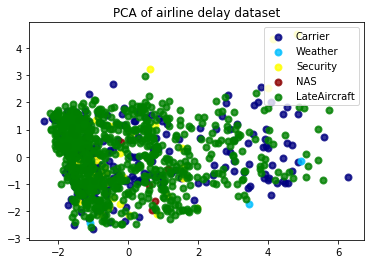

In [65]:
target_names = np.array(['Carrier', 'Weather', 'Security', 'NAS', 'LateAircraft'])
plt.figure()
colors = ['navy', 'DeepSkyBlue', 'yellow', 'darkred', 'green']
lw = 2
cm = plt.get_cmap('jet')

for color, i, target_name in zip(colors, [1, 2, 3, 4, 5], target_names):
    plt.scatter(delay_data_r[delay_cause == i, 0], delay_data_r[delay_cause == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name, cmap=cm)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of airline delay dataset')

plt.show()


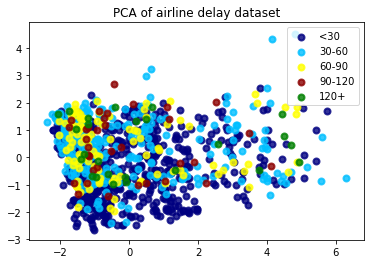

In [66]:
delay_cause = delay_classes.TotalDelay
delay_cause = np.array(delay_cause)

target_names = np.array(['<30', '30-60', '60-90', '90-120', '120+'])
plt.figure()
colors = ['navy', 'DeepSkyBlue', 'yellow', 'darkred', 'green']
lw = 2
cm = plt.get_cmap('jet')

for color, i, target_name in zip(colors, [1, 2, 3, 4, 5], target_names):
    plt.scatter(delay_data_r[delay_cause == i, 0], delay_data_r[delay_cause == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name, cmap=cm)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of airline delay dataset')

plt.show()


In [67]:
#3D PCA plot for DELAY DATA 
#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=delay_data_r[:,0],
    y=delay_data_r[:,1],
    z=delay_data_r[:,2],
    mode='markers',
    marker=dict(
        size='16',
        color = delay_classes['TotalDelay'], #set color equal to a variable
        colorscale='Viridis',
        showscale=True,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter-delay-pca')

In [68]:
# 3D PCA plot for CANCELLED DATA 
#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
#print(canc_data_r[cancelled_Y == i],0])
#blah = canc_data_r[cancelled_Y == 1],0)
#print(cancelled_Y)
#print(cancelled_classes)
print(canc_data_r)
print(canc_data_r[:,0])

trace1 = go.Scatter3d(
    x=canc_data_r[:,0],
    y=canc_data_r[:,1],
    z=canc_data_r[:,2],
    mode='markers',
    marker=dict(
        size='16',
        color = cancelled_Y, #set color equal to a variable
        colorscale='Viridis',
        showscale=True,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
figC3 = go.Figure(data=data, layout=layout)
py.iplot(figC3, filename='GDC-airline-delay-3')

[[ -762.05586826  -377.84123202   -40.85826324]
 [ -766.04414859   -77.9402243    209.38862421]
 [ -751.13173669  -339.41718489  -253.58762956]
 ..., 
 [  526.1406357   1269.44845887   406.13297289]
 [  962.78665855  1177.20678447   -25.13131555]
 [ -649.03089301  1107.86749481  -794.27013237]]
[-762.05586826 -766.04414859 -751.13173669 ...,  526.1406357   962.78665855
 -649.03089301]


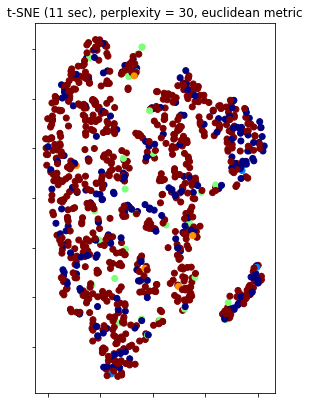

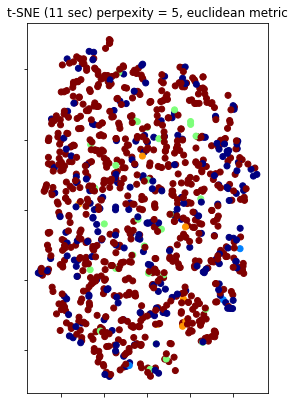

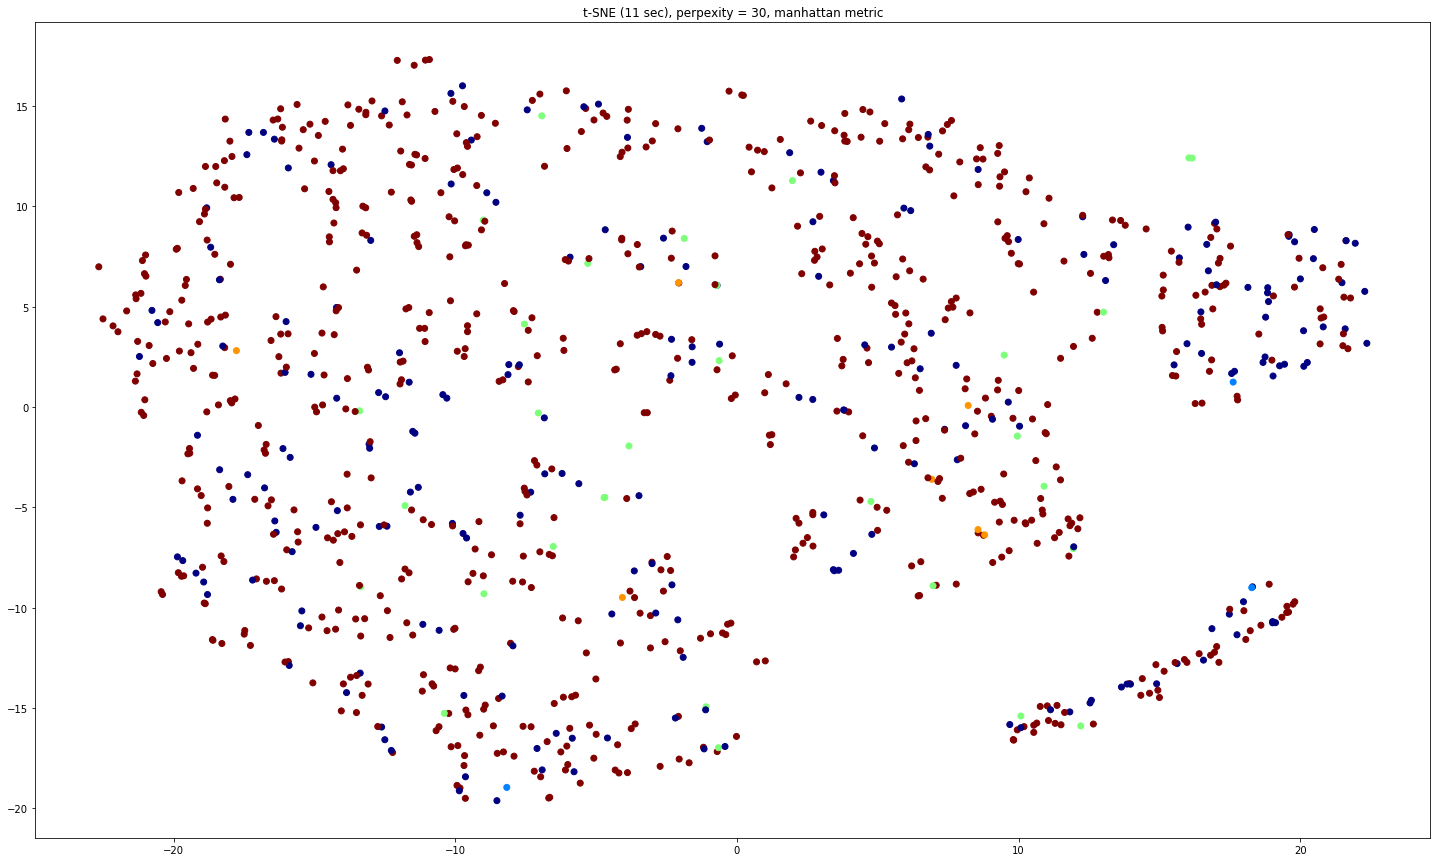

(-0.055000000000000007,
 0.055000000000000007,
 -0.055000000000000007,
 0.055000000000000007)

In [69]:
#tsne for DELAY data
n_components = 2
n_neighbors = 5

tsne_colors = delay_classes['MaxDelay']
tsne_colors = np.array(tsne_colors)
#print(tsne_colors)

fig = plt.figure(figsize=(25, 15))

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
tsne2 = manifold.TSNE(n_components=n_components, init='pca', perplexity=5, metric='euclidean')
tsne3 = manifold.TSNE(n_components=n_components, init='pca', perplexity=30, metric='manhattan')
tsne4 = manifold.TSNE(n_components=n_components, init='pca', perplexity=30, metric='minkowski')
data_tsne = tsne.fit_transform(delay_data_small)
data_tsne_2 = tsne2.fit_transform(delay_data_small)
data_tsne_3 = tsne3.fit_transform(delay_data_small)
#data_tsne_4 = tsne4.fit_transform(delay_data_small)
y=np.array([0,1,2,3,4])

t1 = time()
ax = fig.add_subplot(2, 5, 10)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=tsne_colors, cmap=cm)
plt.title("t-SNE (%.2g sec), perplexity = 30, euclidean metric" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

fig2 = plt.figure(figsize=(25, 15))
ax = fig2.add_subplot(2, 5, 10)
plt.scatter(data_tsne_2[:, 0], data_tsne_2[:, 1], c=tsne_colors, cmap=cm)
plt.title("t-SNE (%.2g sec) perpexity = 5, euclidean metric" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

fig3 = plt.figure(figsize=(25, 15))
ax = fig2.add_subplot(2, 5, 10)
plt.scatter(data_tsne_3[:, 0], data_tsne_3[:, 1], c=tsne_colors, cmap=cm)
plt.title("t-SNE (%.2g sec), perpexity = 30, manhattan metric" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

#fig4 = plt.figure(figsize=(25, 15))
#ax = fig2.add_subplot(2, 5, 10)
#plt.scatter(data_tsne_4[:, 0], data_tsne_4[:, 1], c=tsne_colors, cmap=cm)
#plt.title("t-SNE (%.2g sec), perpexity = 30, minkowski metric" % (t1 - t0))
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.yaxis.set_major_formatter(NullFormatter())

plt.show()
plt.axis('tight')


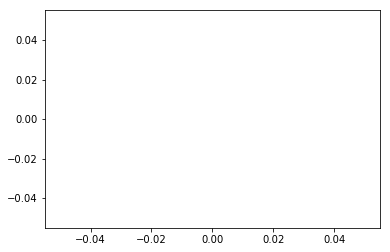

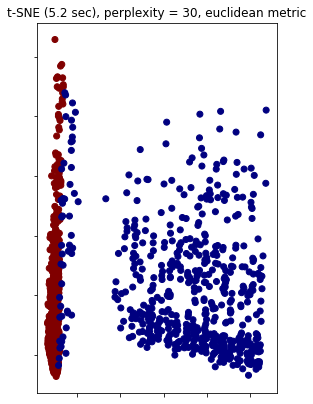

(-0.055000000000000007,
 0.055000000000000007,
 -0.055000000000000007,
 0.055000000000000007)

In [70]:
#t-SNE for CANCELLED data
n_components = 2
n_neighbors = 5

tsne_colors = cancelled_classes
tsne_colors = np.array(tsne_colors)
#print(tsne_colors)

fig = plt.figure(figsize=(25, 15))

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
tsne2 = manifold.TSNE(n_components=n_components, init='pca', perplexity=5, metric='euclidean')
tsne3 = manifold.TSNE(n_components=n_components, init='pca', perplexity=30, metric='manhattan')
tsne4 = manifold.TSNE(n_components=n_components, init='pca', perplexity=30, metric='minkowski')
data_tsne_canc = tsne.fit_transform(mixed_cancelled)
#data_tsne_2 = tsne2.fit_transform(delay_data_small)
#data_tsne_3 = tsne3.fit_transform(delay_data_small)
#data_tsne_4 = tsne4.fit_transform(delay_data_small)
y=np.array([0,1])

t1 = time()
ax = fig.add_subplot(2, 5, 10)
plt.scatter(data_tsne_canc[:, 0], data_tsne_canc[:, 1], c=tsne_colors, cmap=cm)
plt.title("t-SNE (%.2g sec), perplexity = 30, euclidean metric" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

plt.show()
plt.axis('tight')

In [71]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
tsne2 = manifold.TSNE(n_components=3, init='pca', perplexity=30, metric='manhattan')

Y = tsne2.fit_transform(delay_data_small)
data_tsne = tsne2.fit_transform(delay_data_small)

print(sk.manifold.TSNE.get_params(tsne))
trace1 = go.Scatter3d(
    x=Y[:, 0],
    y=Y[:, 1],
    z=Y[:, 2],
    mode='markers',
    marker=dict(
        size='16',
        color = delay_classes['TotalDelay'], #set color equal to a variable
        colorscale='Viridis',
        showscale=True,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig1 = go.Figure(data=data, layout=layout)
py.iplot(fig1, filename='simple-3d-scatter')

{'angle': 0.5, 'early_exaggeration': 4.0, 'init': 'pca', 'learning_rate': 1000.0, 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 3, 'n_iter': 1000, 'n_iter_without_progress': 30, 'perplexity': 30.0, 'random_state': 0, 'verbose': 0}
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gdcutting/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [74]:
tsne_canc = manifold.TSNE(n_components=3, init='pca', random_state=0)
tsne2_canc = manifold.TSNE(n_components=3, init='pca', perplexity=30, metric='manhattan')

Y1 = tsne2.fit_transform(mixed_cancelled)
data_tsne_canc = tsne2.fit_transform(mixed_cancelled)

trace1 = go.Scatter3d(
    x=Y1[:, 0],
    y=Y1[:, 1],
    z=Y1[:, 2],
    mode='markers',
    marker=dict(
        size='16',
        color = cancelled_Y, #set color equal to a variable
        colorscale='Viridis',
        showscale=True,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig5 = go.Figure(data=data, layout=layout)
py.iplot(fig5, filename='airline-cancellation-tsne')

In [78]:
#k-means clustering for prediction

from sklearn.cluster import KMeans
import seaborn as sn

# confusion matrix
def cm(x):
    conf = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            conf[i,j] = np.sum(np.where(predicted==i,1,0)*np.where(targets==j,1,0))
    return conf

# create target and feature arrays
features = np.asarray(canc_data_r)
targets = np.asarray(cancelled_classes)

# fit 2 clusters
k = sk.cluster.KMeans(n_clusters=2).fit(features)
predicted = k.predict(features)
predicted
# reverse indexing
predicted = 1-predicted

# check accuracy
np.equal(predicted, targets).sum()/predicted.shape[0]
# print confusion matrix
cm1 = cm(k)
print("Confusion Matrix of KMeans Classifier with 2 Clusters" )
print(cm1)
sn.heatmap(cm1)

# fit 3 clusters
#k = sk.cluster.KMeans(n_clusters=3).fit(features)
#k.get_params()
# predict model 
#predicted = k.predict(features)
# reverse cluster indexing
#predicted = 1-pred
# find percentage of correct classifications
#np.equal(predicted, targets).sum()/pred.shape[0]

Confusion Matrix of KMeans Classifier with 2 Clusters
[[ 326400.  344352.]
 [ 413400.  436137.]]


In [ ]:
import threading, sqlite3, re, array, random

from time import time, sleep

CLUSTERS = 3
ITERATIONS = 5

"""Thread for updating progress asynchronously"""
class OutputThread(threading.Thread):
	def __init__(self, total_flights=1, label="Progress", suffix="%"):
		threading.Thread.__init__(self)
		self.current_flight = 0
		self.total_flights = total_flights
		self.running = True
		self.label = label
		self.suffix = suffix

	def run(self):
		while self.running:
			print("\r{} {:.1f}{}".format(self.label, (self.current_flight / self.total_flights) * 100, self.suffix), end="")
			sleep(0.1)

	"""Stop thread"""
	def stop(self, text=""):
		self.running = False
		print("\r{}".format(text)) # Overwrite label with final text

	"""Update progress"""
	def update(self, current_flight):
		self.current_flight = current_flight

"""Iterator for flights in database"""
class FlightIterator:
	def __init__(self, cursor):
		self.cursor = cursor

	def __iter__(self):
		return self

	def __next__(self):
		result = self.cursor.fetchone()
		if result == None:
			raise StopIteration
		else:
			return Flight.from_arguments(*result)

"""Container class for storing flight information"""
class Flights:
	def __init__(self, headers):
		self.connection = sqlite3.connect("flights.db")
		c = self.connection.cursor()
		# c.execute("PRAGMA foreign_keys = ON")
		c.execute("CREATE TABLE IF NOT EXISTS headers (header TEXT)")
		count = c.execute("SELECT COUNT(*) FROM headers").fetchone()[0]
		if count == 0:
			c.executemany("INSERT INTO headers VALUES (?)", [(i,) for i in headers])
			# for row in c.execute("SELECT * FROM headers"):
			# 	print(row[0])
			c.execute("CREATE TABLE IF NOT EXISTS flights ({} INTEGER)".format(" INTEGER, ".join(headers)))
			
		self.connection.commit()

	def __iter__(self):
		return FlightIterator(self.connection.execute("SELECT rowid, * FROM flights"))

	def add_data(self, month, day_of_month, day_of_week, dep_time, crs_dep_time, arr_time,
			crs_arr_time, flight_num, actual_elapsed_time, crs_elapsed_time, air_time, arr_delay,
			dep_delay, distance, taxi_in, taxi_out, carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay):
		
		# Convert function arguments to list (this is ugly af and I hate myself for it but time is of the essence)
		args = [month, day_of_month, day_of_week, dep_time, crs_dep_time, arr_time,
			crs_arr_time, flight_num, actual_elapsed_time, crs_elapsed_time, air_time, arr_delay,
			dep_delay, distance, taxi_in, taxi_out, carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay]
		
		# Throw the 22 arguments into a parameterized SQL statement
		self.connection.execute("INSERT INTO flights VALUES ({})".format(",".join(["?"] * 21)), args)

	def save(self):
		self.connection.commit()

	def count(self):
		return self.connection.execute("SELECT COUNT(*) FROM flights").fetchone()[0]

	def random_selection(self, num):
		result = list()
		flights = self.connection.execute("SELECT rowid, * FROM flights ORDER BY RANDOM() LIMIT ?", (num,)).fetchall()
		for flight in flights:
			result.append(Flight.from_arguments(*flight))

		return result

	def add_flight(self, flight):
		d = flight.data
		l = [d["year"], d["month"], d["day_of_month"], d["day_of_week"], d["dep_time"], d["crs_dep_time"], d["arr_time"], 
			 d["crs_arr_time"], d["flight_num"], d["actual_elapsed_time"], d["crs_elapsed_time"], d["air_time"], d["arr_delay"],
			 d["dep_delay"], d["distance"], d["taxi_in"], d["taxi_out"], d["carrier_delay"], d["weather_delay"], d["nas_delay"],
			 d["security_delay"], d["late_aircraft_delay"]]

		# Throw the 22 arguments into a parameterized SQL statement
		self.connection.execute("INSERT INTO flights VALUES ({})".format(",".join(["?"] * 22)), l)

"""Class representing one flight"""
class Flight:
	def __init__(self, **kwargs):
		self.data = kwargs

	def __getitem__(self, key):
		return self.data[key]

	def __setitem__(self, key, value):
		self.data[key] = value

	def __str__(self):
		return str(self.data)

	def __repr__(self):
		return repr(self.data)

	def keys(self):
		return self.data.keys()

	def copy(self):
		return Flight(**dict(self.data))

	@staticmethod
	def from_arguments(rowid, month, day_of_month, day_of_week, dep_time, crs_dep_time, arr_time,
			crs_arr_time, flight_num, actual_elapsed_time, crs_elapsed_time, air_time, arr_delay,
			dep_delay, distance, taxi_in, taxi_out, carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay):
		
		d = dict([("rowid", rowid), ("month", month), ("day_of_month", day_of_month), ("day_of_week", day_of_week),
			("dep_time", dep_time), ("crs_dep_time", crs_dep_time), ("arr_time", arr_time), ("crs_arr_time", crs_arr_time),
			("flight_num", flight_num), ("actual_elapsed_time", actual_elapsed_time), ("crs_elapsed_time", crs_elapsed_time),
			("air_time", air_time), ("arr_delay", arr_delay), ("dep_delay", dep_delay), ("distance", distance), ("taxi_in", taxi_in),
			("taxi_out", taxi_out), ("carrier_delay", carrier_delay), ("weather_delay", weather_delay), ("nas_delay", nas_delay),
			("security_delay", security_delay), ("late_aircraft_delay", late_aircraft_delay)])
		return Flight(**d)

# Concert a CamelCase name to a lowercase name with underscores (e.g. camel_case)
# From: https://stackoverflow.com/a/1176023/697674
def to_underscore(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def preprocess():
	with open("data\\DelayedFlights.csv", "r") as f:
		headers = []
		header_pos = dict()
		clusters = array.array("b")
		header_line = f.readline().strip()[1:].split(",")
		
		# Parse data headers
		for i in range(len(header_line)):
			# Ignored Year, Cancelled, CancellationCode, and Diverted, and string columns
			if header_line[i] in ("Year", "Cancelled", "CancellationCode", "Diverted", "UniqueCarrier", "TailNum", "Origin", "Dest"):
				continue # Skip column

			# Record row and row position
			headers.append(header_line[i])
			header_pos[header_line[i]] = i+1
		
		flights = Flights(headers)

		if flights.count() == 0:
			print("Processing fresh data")
			o = OutputThread(label="Processing line", suffix="")
			try:
				o.start()
				line_num = 0
				for line in f:
					# Update progress
					line_num += 1
					o.update(line_num / 100)

					# Shrink the dataset
					# if random.randint(0, 5) > 0:
					# 	continue

					# Split row into fields
					data_line = line.strip().split(",")

					# Filter out all rows with missing data:
					if "" in data_line:
						continue

					# Parse row
					d = dict()
					for header in headers:
						# If data is numerical, convert to integer
						temp = data_line[header_pos[header]].split(".")[0] # Strip decimal point and trailing 0
						d[to_underscore(header)] = int(temp) if temp.isdecimal() else temp # Convert if necessary and store in object

					# Add row to dataset
					flights.add_data(**d)

				# Commit changes to disk
				flights.save()
				o.stop("Processing complete.              ")
			except KeyboardInterrupt:
				o.stop("Processing aborted.               ")
				exit()
			except Exception:
				o.stop("Processing aborted.               ")
				raise
		else:
			print("Using cached data.")
			
	# Initialize clusters array
	clusters.extend([-1]*flights.count())
		
	return flights, clusters

# Calculate distance between a flight and a cluster centroid
def distance(flight, centroid):
	d = 0
	for key in flight.keys():
		if isinstance(flight[key], int) and key not in ("flight_num", "rowid", "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"): # Only use numeric data fields
			d += (flight[key] - centroid[key]) ** 2 # Use Euclidean distance squared (to avoid square root)

	return d

def assign_cluster(flight, centroids, clusters):
	min_d = float("inf")
	min_centroid = None

	for i in range(len(centroids)):
		d = distance(flight, centroids[i])
		if d < min_d:
			min_d = d
			min_centroid = i

	if min_centroid == None:
		print("Distance metric failed for flight:", flight)
		
	clusters[flight["rowid"]-1] = min_centroid

def update_centroids(centroids, o):
	centroid_counts = [0 for i in range(len(centroids))]
	centroid_totals = [Flight.from_arguments(*([0]*22)) for i in range(len(centroids))]
	# print(centroid_totals)
	
	current_flight = flights.count()
	for flight in flights:	
		# Update progress
		o.update(current_flight)
		current_flight += 1
	
		# index = flight.cluster
		index = clusters[flight["rowid"]-1]
		if index == None:
			print("Invalid index:", flight)
			continue

		centroid_counts[index] += 1

		for key in flight.keys():
			if isinstance(flight.data[key], int):
				centroid_totals[index][key] += flight[key]

	for i in range(len(centroids)):
		for key in centroids[i].keys():
			centroids[i][key] = (centroid_totals[i][key] / centroid_counts[i]) if centroid_counts[i] > 0 else 0

def kmeans(k):
	centroids = flights.random_selection(k)
	old_centroids = [i.copy() for i in centroids]

	for i in range(ITERATIONS):
		# Create and start output thread
		o = OutputThread(flights.count()*2, "Iteration {}... ".format(i+1))
		o.start()
		current_flight = 0
		
		# Update all flights
		try:
			start = time()

			for flight in flights:
				assign_cluster(flight, centroids, clusters)
				
				# Update progress
				o.update(current_flight)
				current_flight += 1

			update_centroids(centroids, o)

			end = time()

			o.stop("Iteration {}... Complete. Processing took {:.1f} seconds.".format(i+1, end-start))
		except KeyboardInterrupt:
			o.stop("Processing aborted.             ")
			exit()

		except Exception:
			o.stop("Processing aborted.             ")
			raise
	
		print("Change:", sum([distance(centroids[i], old_centroids[i]) for i in range(k)]))
		old_centroids = [i.copy() for i in centroids]
		
		result = [0]*CLUSTERS
		for i in range(CLUSTERS):
			result[i] = clusters.count(i)
		print(result)

if __name__ == "__main__":

	print("Preprocessing...")
	start = time()
	flights, clusters = preprocess()
	end = time()
	print("Done. Preprocessing took {:.1f} seconds. Processed {} records.\n".format(end-start, flights.count()))

	print("Processing...")
	start = time()
	kmeans(CLUSTERS)
	end = time()
	print("Done. Processing took {:.1f} seconds.".format(end-start))


	confusion_matrix = [[0, 0, 0, 0, 0],
						[0, 0, 0, 0, 0],
						[0, 0, 0, 0, 0],
						[0, 0, 0, 0, 0],
						[0, 0, 0, 0, 0]]
	for flight in flights:
		l = [flight["carrier_delay"], flight["weather_delay"], flight["nas_delay"], flight["security_delay"], flight["late_aircraft_delay"]]
		confusion_matrix[clusters[flight["rowid"]-1]][l.index(max(l))] += 1

	for row in confusion_matrix:
		print("\t".join([str(i) for i in row]))

